In [1]:
import pandas as pd
### Import Libraries
# Azure Data Lake libraries
import common.utils.azure_data_lake_interface as adl

# data analysis and visualization
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt

# config libraries
import common.config
from common.utils.configuration_management import load_config

In [11]:
# attach to the data lake
config = load_config(common.config, "datalake_config.json")
service_client = adl.get_azure_service_client(config["blob_url"])
file_system_client = adl.get_azure_file_system_client(service_client, "consolidated")

# get data
data_state = "curated"
trans_type = "CustInvc"
filename = f"transaction/{trans_type}ItemLineItems_{data_state}.parquet"
df = adl.get_parquet_file_from_data_lake(file_system_client, f"{data_state}/netsuite", filename)

In [12]:
period_map = {
    'Y': 'Year',
    'M': 'Month',
    'W': 'Week',
    'D': 'Day',
}
period = 'M'
period_str = period_map[period]

period_data = df.copy()
period_data[period_str] = period_data["created_date"].dt.to_period(period)

In [13]:
group_focus = "sku"
weighted_margin = period_data.groupby([period_str, group_focus]).agg(
    total_costs=('total_cost', 'sum'),
    total_revenues=('total_amount', 'sum'),
    item_name=('item_name', 'first'),
).assign(
    weighted_margin=lambda x: round((x.total_revenues - x.total_costs) * 100 / x.total_revenues, 2)
)

In [22]:
group_focus = "sku"
N = 2
top_revenue_for_focus_group = period_data.groupby([group_focus]).agg(
    total_revenues=('total_amount', 'sum'),
).sort_values('total_revenues', ascending=False).head(N)

In [23]:
top_focus_group_weighted_margin = weighted_margin[
    weighted_margin.index.get_level_values('sku').isin(top_revenue_for_focus_group.index)]

In [24]:
# Make sure dates are sorted
# chart_data = weighted_margin.sort_values(by=period_str, ascending=True)
chart_data = top_focus_group_weighted_margin.sort_values(by=period_str, ascending=True)

# restrict data to a specific window
start_period = pd.Period('2024-01', freq=period)
mask = chart_data.index.get_level_values(period_str) >= start_period
chart_data = chart_data[mask]

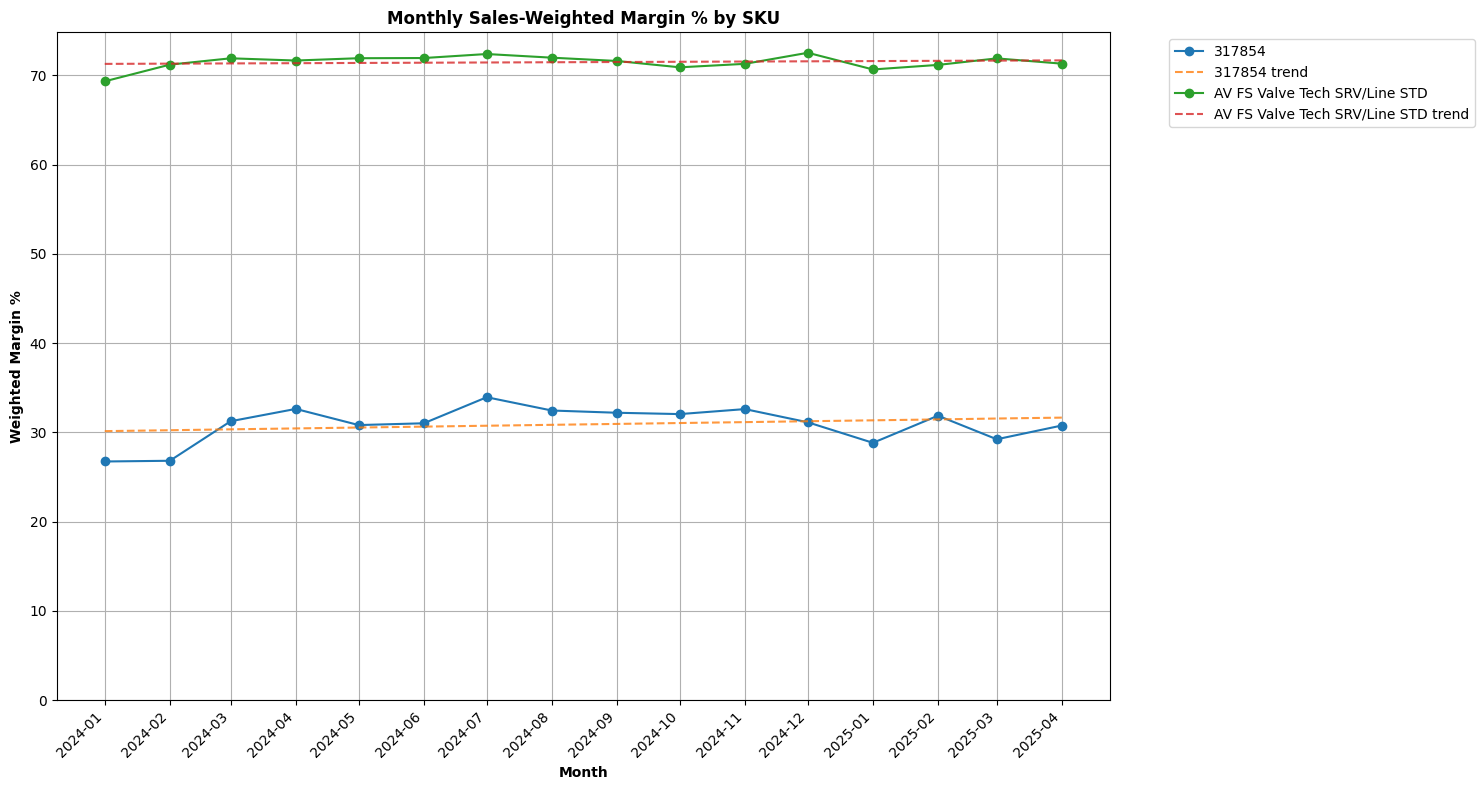

In [25]:
# Set the interval for x-axis labels
interval_map = {
    'Y': 1,
    'M': 1,
    'W': 3,
    'D': 21,
}
n = interval_map[period]

plt.figure(figsize=(15, 8))
for group in chart_data.index.get_level_values(group_focus).unique():
    # slice out all rows for this focus group
    group_data = chart_data.xs(group, level=group_focus)

    # pull out the period index as timestamps
    dates = group_data.index.get_level_values(period_str).to_timestamp()
    y     = group_data['weighted_margin'].values

    # plot actuals
    plt.plot(dates, y, marker='o', label=group_data['item_name'].iat[0])
    
    try:
        # compute/plot trend line
        x = np.arange(len(y))
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)

        plt.plot(dates, p(x), '--', alpha=0.8, label=f'{group_data["item_name"].iat[0]} trend')
    except LinAlgError:
        pass
        

# get smart title
title_map = {
    "subsidiary_name": "Subsidiary",
    "sku": "SKU",
    "manufacturer": "Manufacturer",
}
title = title_map[group_focus]

plt.xlabel(period_str, fontweight='bold')
plt.ylabel('Weighted Margin %', fontweight='bold')
plt.title(f'{period_str}ly Sales-Weighted Margin % by {title}', fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# build x-tick positions and labels from the period level
format_map = {
    'Y': '%Y',
    'M': '%Y-%m',
    'W': '%Y-%m-%d',
    'D': '%Y-%m-%d',
}
uniq = pd.Index(
    chart_data.index
              .get_level_values(period_str)
              .to_timestamp()
              .unique()
).sort_values()

positions = uniq[::n]
labels    = [d.strftime(format_map[period]) for d in positions]

# place ticks at the actual datetime positions
plt.xticks(positions, labels, rotation=45, ha='right')

plt.grid(True)
plt.ylim(bottom=0)
plt.tight_layout()